In [1]:
import json

#To load the data from disk into memory
#review file imported
with open("data/review_sample_cleveland.json") as f:
    reviews = f.read().strip().split("\n")
    
reviews = [json.loads(review) for review in reviews] 
#extracting stars and text in two different list for each review
#We now have two arrays of data: the text of each review and the respective star-rating. 
#Our task is to train a system that can predict the star-rating from looking at only the review text
texts = [review['text'] for review in reviews]
stars = [review['stars'] for review in reviews]
print len(texts)
print len(stars)

91057
91057


In [2]:
from collections import Counter
def balance_classes(xs, ys):
    """Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
#creating a counter so that number of reviews in each category(1 star, 2 star etc) are equal 
# the least common class is the maximum number we want for all classes
#In machine learning, it’s common to separate our data into features and labels. 
#In our case, the review texts (the input data) will be converted into features and the star ratings (what we are trying to predict) are the labels. 
#You’ll often see these two categories referred to as X and Y respectively. 
#Adding the following method to a cell will allow us to balance a dataset by removing over-represented samples from the two lists.
    max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i, y in enumerate(ys):
        if num_added[y] < max_allowable:
            new_ys.append(y)
            new_xs.append(xs[i])
            num_added[y] += 1
    return new_xs, new_ys

In [3]:
print(Counter(stars))
balanced_x, balanced_y = balance_classes(texts, stars)
print(Counter(balanced_y))

Counter({5: 36275, 4: 25167, 3: 11718, 1: 9823, 2: 8074})
Counter({1: 8074, 2: 8074, 3: 8074, 4: 8074, 5: 8074})


In [4]:
#TF-IDF therefore normalises the count of each word in each text by the number of times that that word occurs
#in all of the texts. If a word occurs in nearly all of the texts, we deem it to be less significant. 
#If it only appears in several texts, we regard it as more important.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
vectorizer = TfidfVectorizer(stop_words='english',max_features=500,ngram_range=(1,2))
t1 = datetime.now()

# the 'fit' builds up the vocabulary from all the reviews
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
vectors = vectorizer.fit_transform(balanced_x)
print(datetime.now() - t1)
print vectors.shape

0:00:14.939145
(40370, 500)


# Classification Models

In [6]:
from sklearn.model_selection import train_test_split
#model to train 66% and test 33%
names=[]
results=[]
X_train, X_test, y_train, y_test = train_test_split(vectors, balanced_y, test_size=0.33, random_state=42)

The classifier we’ll use is a Linear Support Vector Machine (SVM), which has been shown to perform well on several text classifications tasks.

In [7]:
from sklearn.svm import LinearSVC

# initialise the SVM classifier
classifier = LinearSVC()

# train the classifier
t1 = datetime.now()
classifier.fit(X_train, y_train)
print(datetime.now() - t1)

0:00:02.079510


next, The first line of the output displays the ratings our classifier predicted for the first ten reviews in our dataset,and the second line shows the actual ratings of the same reviews.

In [8]:
preds = classifier.predict(X_test)
print(list(preds[:10]))
print(y_test[:10])

[5, 1, 1, 5, 3, 3, 5, 3, 5, 3]
[5, 1, 1, 5, 3, 2, 5, 3, 4, 2]


In [9]:
#predicting accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, preds))
results.append(accuracy_score(y_test, preds))
names.append('SVM')

0.5207535840276214


# #KNN

In [10]:
#knn classfrom sklearn.neighbors import KNeighborsClassifierifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=95)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

from sklearn import metrics
print('Accuracy of nearest neighbor classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))
results.append(accuracy_score(y_test, y_pred))
names.append('KNN')

Accuracy of nearest neighbor classifier on test set: 0.44


# #logistic Regression

In [11]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
from sklearn import metrics
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
results.append(accuracy_score(y_test, y_pred))
names.append('LogisticReg')

Accuracy of logistic regression classifier on test set: 0.52


# #Multinomial Naive Bayes

In [13]:
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB()
X=vectors
y=balanced_y
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=0)

clf.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

y_pred=clf.predict(X_test)
print('Accuracy of Multinomial on test set: {:.2f}'.format(clf.score(X_test, y_test)))
results.append(accuracy_score(y_test, y_pred))
names.append('MultinomialNaiveBayes')

Accuracy of Multinomial on test set: 0.50


  models  Accuracy
1    KNN  0.443519


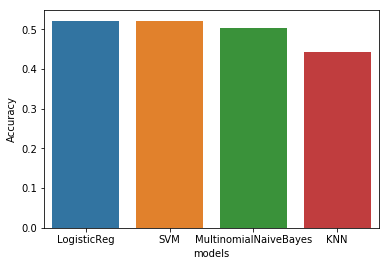

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
result_df = pd.DataFrame({'models': names, 'results': results})
result_df.columns = ['models', 'Accuracy']
result_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print result_df.tail(1)

# plot results
sns.barplot(x='models', y='Accuracy', data=result_df);

# #Regression Model

## Linear Regression model

In [16]:
# applying linear regression model by giving X as concat matrix and y as stars column

# import the class
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
names=[]
results=[]
X=vectors
y=balanced_y

#dividing the data in to training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state =1)
print(X_train.shape)
print(X_test.shape)

(32296, 500)
(8074, 500)


In [17]:
# instantiate the model (using the default parameters)
import numpy as np
lr=LinearRegression()

# fit the model with data
lr.fit(X_train,y_train)

pred = lr.predict(X_test)

score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
results.append(score)
names.append('Linear Regression')

Final score (MSE): 0.905238271725
Final score (RMSE): 0.951440104119


In [18]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
lr=DecisionTreeRegressor()

# fit the model with data
lr.fit(X_train,y_train)

pred = lr.predict(X_test)

score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
results.append(score)
names.append('DecisionTreeRegressor')

Final score (MSE): 1.93893206589
Final score (RMSE): 1.39245540894


In [19]:
import numpy as np
lr=SVR()

# fit the model with data
lr.fit(X_train,y_train)

pred = lr.predict(X_test)

score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
results.append(score)
names.append('SVR')

Final score (MSE): 1.25320985736
Final score (RMSE): 1.11946856024


              models     RMSE
0  Linear Regression  0.95144


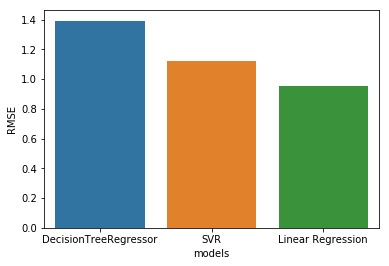

In [20]:
result_df = pd.DataFrame({'models': names, 'results': results})
result_df.columns = ['models', 'RMSE']
result_df.sort_values(by='RMSE', ascending=False, inplace=True)
print result_df.tail(1)

# plot results
sns.barplot(x='models', y='RMSE', data=result_df);